In [2]:
# Importing necessary libraries
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt 

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

#data cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x : ast.literal_eval(x) if pd.notna(x) else x)

c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## What are the most demanded skills for the top 3 most popular data roles?

### Methodology

1. **Clean and format the skills column**  
   Convert the skills data into a structured list format for analysis.

2. **Compute skill frequency by job role**  
   Group postings by `job_title_short` and count skill occurrences.

3. **Calculate skill demand percentage**  
   Convert counts into percentages to compare roles fairly.

4. **Visualize the results**  
   Plot the top skills for each of the three most common job roles.



## 🧹 Clean and Structure the Skills Column

To analyze skill demand accurately, I first focus on job postings in the **United States** and prepare the skills data for counting.

### Steps performed:
1. **Filter U.S. job postings**  
   This ensures the analysis is consistent within one job market.

2. **Explode the `job_skills` column**  
   Since each job posting contains multiple skills stored as a list, I use `.explode()` to transform the dataset so that:
   - each row represents **one job posting + one skill**
   - skills can be counted and grouped correctly

✅ This step creates a clean structure that makes it possible to calculate skill frequency and demand percentages by job role.


In [3]:
df_US = df[df['job_country'] == 'United States'].copy()
df_US_exploded = df_US.explode('job_skills')
df_US_exploded[['job_title_short', 'job_skills']]

,job_title_short,job_skills
0,Senior Data Engineer,None
3,Data Engineer,python
3,Data Engineer,c++
3,Data Engineer,java
3,Data Engineer,matlab
...,...,...
785692,Data Scientist,r
785703,Data Analyst,None
785705,Data Analyst,sql
785705,Data Analyst,python


## 🔢 Count Skills per Job Title

After restructuring the dataset so that each row represents a single skill, I calculate how often each skill appears for every job role.

### What this step does:
- Groups the data by:
  - `job_title_short` (job role)
  - `job_skills` (individual skill)
- Counts how many times each skill appears within each role using `.size()`

✅ The result is a table showing the **skill frequency (`skill_count`)** for each job title, which is essential for measuring demand and later calculating skill percentages.


In [4]:
df_US_exploded_gr = df_US_exploded.groupby(['job_title_short', 'job_skills']).size().reset_index(name = 'skill_count').sort_values(by = 'skill_count', ascending=False)

df_US_exploded_gr

,job_title_short,job_skills,skill_count
886,Data Scientist,python,42379
472,Data Analyst,sql,34452
921,Data Scientist,sql,30034
351,Data Analyst,excel,27519
890,Data Scientist,r,26022
...,...,...,...
1350,Senior Data Engineer,elixir,1
1819,Software Engineer,sass,1
487,Data Analyst,theano,1
1847,Software Engineer,theano,1


## ⭐ Identify the Top 3 Most Common Roles

To focus the analysis on the most relevant job categories, I first identify the **three most frequently posted data roles** in the U.S. dataset.

I use `value_counts()` on the `job_title_short` column, then select the top 3 roles.  
These roles will be used in the next step to compare which skills employers request most often.


In [5]:
top3_roles = df_US['job_title_short'].value_counts().head(3).index
top3_roles = top3_roles.to_list()
top3_roles

['Data Analyst', 'Data Scientist', 'Data Engineer']

## 📊 Visualize Skill Demand Across the Top 3 Roles

After computing skill frequency per job title, I visualize the **top skills for each of the three most common roles**.

### What the visualization shows:
- Each subplot represents **one job role**
- The bar chart displays the **top skills ranked by frequency**
- This makes it easy to compare how skill requirements differ across roles

✅ **Why this matters:**  
Different roles emphasize different tools and technologies. Visualizing skill demand helps highlight which skills are essential depending on the career path (Data Analyst vs Data Scientist vs Data Engineer).


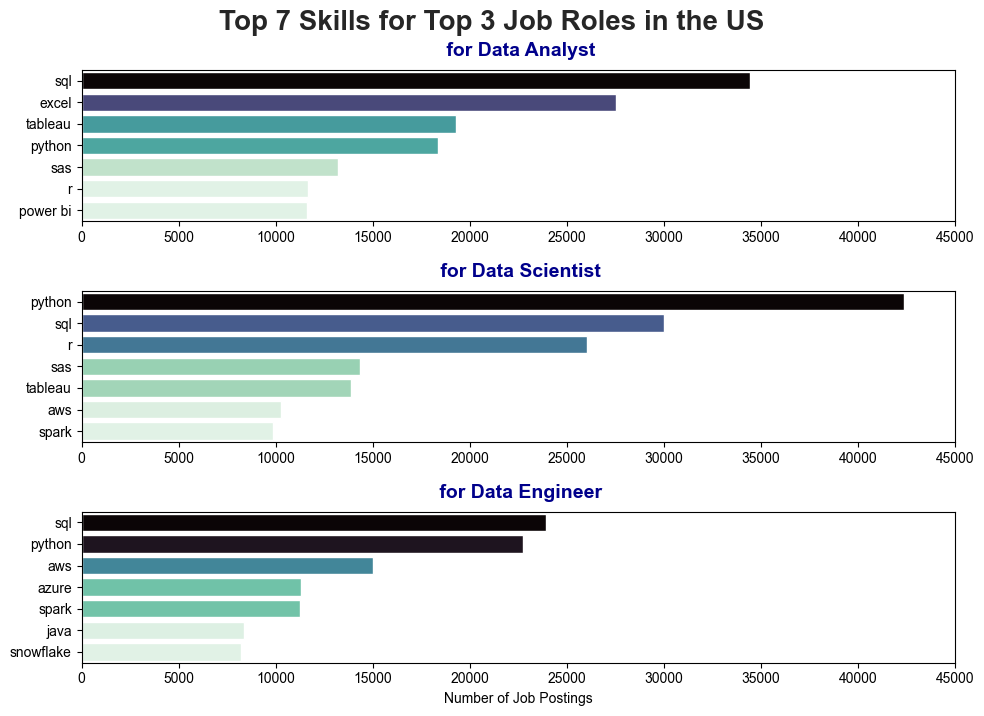

In [6]:
# Plot Skill Counts
fig , ax = plt.subplots(3, 1, figsize = (10,7))  

# Plotting bar plots for top 3 roles
for i, job_t in enumerate(top3_roles):
    sns.set_theme(style='ticks')
    df_US_exploded_gr_plot = df_US_exploded_gr[df_US_exploded_gr['job_title_short'] == job_t].head(7)  # 7 top skills
    sns.barplot(data = df_US_exploded_gr_plot,
                x = 'skill_count',
                y = 'job_skills',
                ax = ax[i],
                hue = 'skill_count',   
                palette = 'mako_r',
                legend=False
                )
    ax[i].set_title(f' for {job_t}',           #setting title
                     fontsize=14,
                     pad = 10,                 #spacing between title and plot
                     fontweight="bold",        #bold font
                     color="darkblue",
                     loc="center",
                     ) 
    
    ax[i].set_xlabel('')

    if i == 2:
      ax[i].set_xlabel('Number of Job Postings') # Adding xlabel only to the last plot

    ax[i].set_ylabel('')
    ax[i].set_xlim(0, 45000) 

plt.tight_layout()
plt.suptitle('Top 7 Skills for Top 3 Job Roles in the US', y=1.02, fontsize=20, fontweight="bold")
plt.show()
    

## 📌 Convert Skill Counts to Percentages

Raw skill counts are useful, but they can be misleading when comparing job roles because some roles have **more job postings than others**.

To make the comparison fair, I convert skill counts into **percentages** by calculating:

**Skill Demand % = (skill_count ÷ total job postings for that role) × 100**

### Steps performed:
1. **Calculate total job postings per job title**  
   I count how many job listings exist for each role using `value_counts()`.

2. **Merge totals into the skill count table**  
   I combine the overall job totals with the skill-level counts using `pd.merge()`.

✅ This creates a standardized metric that allows me to compare skill demand across different roles, even when the number of postings per role varies.


In [7]:
df_US_exploded_gr

,job_title_short,job_skills,skill_count
886,Data Scientist,python,42379
472,Data Analyst,sql,34452
921,Data Scientist,sql,30034
351,Data Analyst,excel,27519
890,Data Scientist,r,26022
...,...,...,...
1350,Senior Data Engineer,elixir,1
1819,Software Engineer,sass,1
487,Data Analyst,theano,1
1847,Software Engineer,theano,1


#### Merging total job counts

In [8]:
jobs_count = df_US['job_title_short'].value_counts().reset_index(name = 'jobs_total')
jobs_prc = pd.merge(df_US_exploded_gr, jobs_count, on = 'job_title_short') 

jobs_prc


,job_title_short,job_skills,skill_count,jobs_total
0,Data Scientist,python,42379,58830
1,Data Analyst,sql,34452,67816
2,Data Scientist,sql,30034,58830
3,Data Analyst,excel,27519,67816
4,Data Scientist,r,26022,58830
...,...,...,...,...
1865,Senior Data Engineer,elixir,1,9289
1866,Software Engineer,sass,1,1814
1867,Data Analyst,theano,1,67816
1868,Software Engineer,theano,1,1814


In [9]:
jobs_prc['skill_percent'] = (jobs_prc['skill_count'] / jobs_prc['jobs_total']) * 100
jobs_prc

,job_title_short,job_skills,skill_count,jobs_total,skill_percent
0,Data Scientist,python,42379,58830,72.036376
1,Data Analyst,sql,34452,67816,50.802171
2,Data Scientist,sql,30034,58830,51.052184
3,Data Analyst,excel,27519,67816,40.578919
4,Data Scientist,r,26022,58830,44.232534
...,...,...,...,...,...
1865,Senior Data Engineer,elixir,1,9289,0.010765
1866,Software Engineer,sass,1,1814,0.055127
1867,Data Analyst,theano,1,67816,0.001475
1868,Software Engineer,theano,1,1814,0.055127


## 📊 Visualize Skill Demand by Percentage (Top 3 Roles)

After converting skill counts into percentages, I visualize the **top skills for each of the three most common data roles** using a standardized metric.

### What this chart shows:
- Each subplot represents a different job role
- Skills are ranked by **percentage of job postings** that mention them
- Percentage labels are added to improve readability and interpretation

✅ **Why this matters:**  
Using percentages allows for a fair comparison between roles, even if one role has significantly more job postings than another. This makes it easier to identify which skills are most essential for each role based on employer demand.


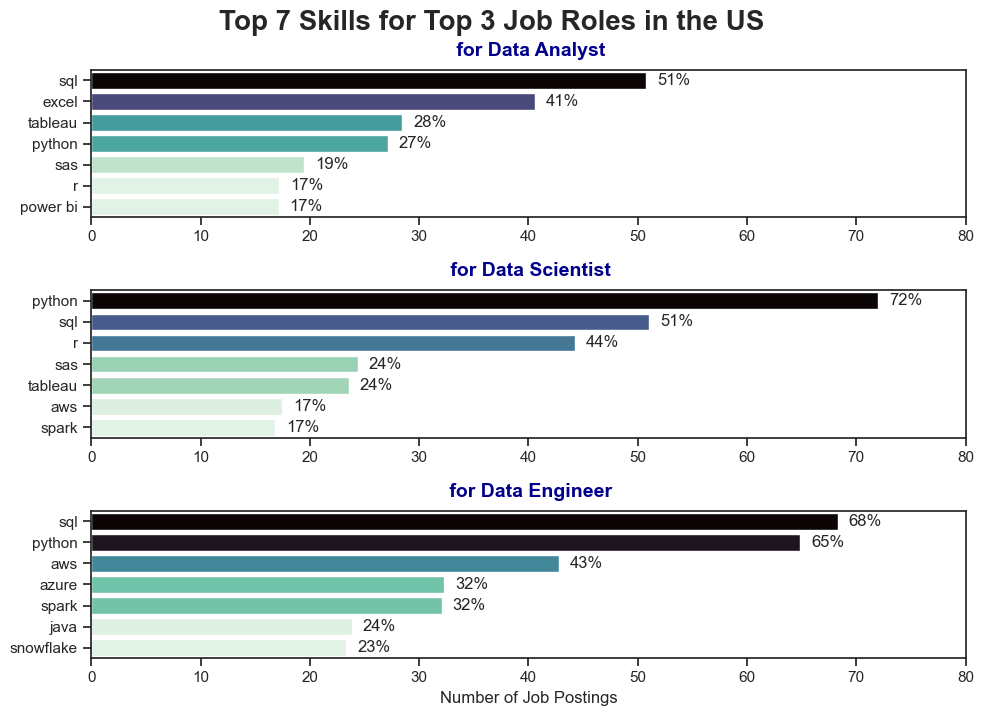

In [10]:
fig , ax = plt.subplots(3, 1, figsize = (10,7))  


for i, job_t in enumerate(top3_roles):
    sns.set_theme(style='ticks')
    df_US_exploded_gr_plot = jobs_prc[jobs_prc['job_title_short'] == job_t].head(7)  # changing to jobs_prc
    sns.barplot(data = df_US_exploded_gr_plot,
                x = 'skill_percent',                                                 #x-axis changed to skill_percent
                y = 'job_skills',
                ax = ax[i],
                hue = 'skill_count',   
                palette = 'mako_r',
                legend=False
                )
    ax[i].set_title(f' for {job_t}',           
                     fontsize=14,
                     pad = 10,                 
                     fontweight="bold",        
                     color="darkblue",
                     loc="center",
                     ) 
    
    for n, m in enumerate(df_US_exploded_gr_plot['skill_percent']):                  # Adding percentage labels
       ax[i].text(m + 1, n, f'{m:.0f}%', va = 'center')
    
    ax[i].set_xlabel('')

    if i == 2:
      ax[i].set_xlabel('Number of Job Postings') 

    ax[i].set_ylabel('') 
    ax[i].set_xlim(0, 80)                                                            #setting x-axis limit
    
plt.tight_layout()
plt.suptitle('Top 7 Skills for Top 3 Job Roles in the US', y=1.02, fontsize=20, fontweight="bold")
plt.show()
    

### Insight
- **Data Analysts** are primarily expected to master foundational tools, with SQL and Excel appearing in the majority of job postings  
- **Data Scientists** show a strong emphasis on programming and statistical skills, particularly Python, SQL, and R  
- **Data Engineers** require more specialized technical expertise, with high demand for SQL, Python, and cloud technologies such as AWS and Azure  
- Python is a common skill across all three roles, highlighting its versatility in the data field  
